## Part 5b Parameter estimation techniques (Bayesian)

* cloned from tutorial_Part5_Parameter_estimation(Bayesian)

The difference is simpler 2-parameter systematics model is used here.

In [1]:
#check python version
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [2]:
#check environment
import os
os.environ['CONDA_DEFAULT_ENV']

'astroconda35'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

#styling
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
fontsize = 18

## import data

In [4]:
from glob import glob

datadir = '.'
path    = os.path.join(datadir,'hatp44_QL*.csv')
file_list = glob(path)
file_list = sorted(file_list)
file_list

['./hatp44_QL_g-band.csv', './hatp44_QL_r-band.csv', './hatp44_QL_z-band.csv']

In [5]:
data={}

bands = 'g,r,z'.split(',')
for fname,b in zip(file_list,bands):
    df=pd.read_csv(fname, delimiter=',', parse_dates=True)
    df = df.drop('Unnamed: 0',axis=1)
    df = df.set_index('BJD(TDB)-2450000')
    data[b] = df
    
data.keys()

dict_keys(['g', 'r', 'z'])

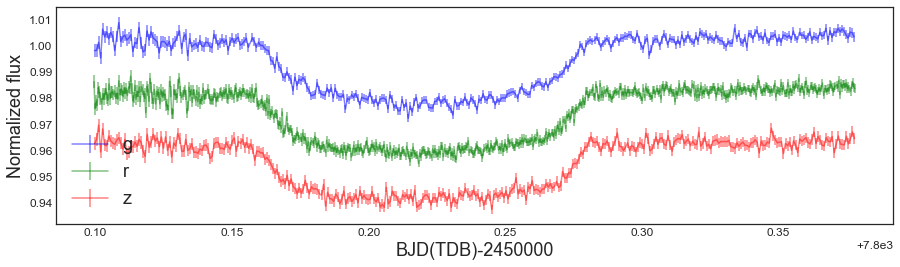

In [6]:
import matplotlib.pyplot as pl
%matplotlib inline

fluxcol =  'flux(r=11.0)'
errcol  =  'err(r=11.0)'

colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))

n=0
for b,c in zip(bands,colors):
    df = data[b]
    offset = n*0.02
    
    time = df.index
    flux = df[fluxcol]
    err  = df[errcol]
    
    ax.errorbar(time, flux-offset, yerr=err, label=b, color=c, alpha=0.5)
    ax.set_ylabel('Normalized flux', fontsize=fontsize)
    n+=1
pl.legend(loc='lower left', fontsize=fontsize)
pl.xlabel('BJD(TDB)-2450000', fontsize=fontsize)

## setting-up the transit model 

See part2.

In [7]:
def scaled_a(p, t14, k, i=np.pi/2, impact_param=0):
    """
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    numer = np.sqrt( (k + 1)**2 - impact_param**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

def u_to_q(u1, u2):
    '''
    convert limb-darkening coefficients
    from u to q
    
    see Eq. 15 & 16 in Kipping 2013
    '''
    q1 = (u1 + u2)**2
    q2 = u1 / (2 * (u1 + u2))
    return q1, q2

def q_to_u(q1, q2):
    '''
    convert limb-darkening coefficients
    from q to u
    
    see Eq. 17 & 18 in Kipping 2013
    '''
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

from pytransit import MandelAgol

def transit_model_q(parameters, period, time, model=MandelAgol()):
    '''
    Compute flux using the Mandel-Agol model:
    
    \frac{I(\mu)}{I(1)} = 1 − u_1(1 − \mu) − u_2(1 − \mu)^2
    
    `parameters` must be a list containing:
    * k  : Rp/Rs: planet-star radius ratio
    * q1 : limb-darkening coefficient (for the linear term)
    * q2 : limb-darkening coefficient (for the quadratice term)
    * tc : transit center
    * a_s: a/Rs: scaled semi-major axis
    * b  : impact parameter
    '''
    k,q1,q2,tc,a,b = parameters
    
    #compute inclination
    inc   = np.arccos(b/a)
    #convert u to q
    u1,u2 = q_to_u(q1, q2)
    #evaluate the model
    m = model.evaluate(time, k, (u1,u2), tc, period, a, inc)
    
    return m

In [8]:
from astropy import units as u

_tc  = 2455696.93695
_P   = 4.301219
_inc = np.deg2rad(89.10)
_t14  = 0.13020
_b    = 0.172

Rp = 1.24 #Rjup
Rs = 0.949*u.Rsun.to(u.Rjup) #Rsol to Rjup
k_ = Rp/Rs

_a_s = 11.52
a_s_  = scaled_a(_P, _t14, k_, i=_inc, impact_param=_b)

tc_0      = 7.8e3+0.22 #-2450000

In [9]:
import limbdark as ld

teff, uteff, logg, ulogg, feh, ufeh=5300,100, 4.460,0.06, 0.33,0.1

ldc_list     = []
ldc_err_list = []
ldp          = []

#for each band
for i in 'g*,r*,z*'.split(','):
    ldc = ld.claret(i, teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4))
    ldp.append(ldc)
    
    #save in list
    #u1,u2
    ldc_list.append([ldc[0],ldc[2]]) #take first and third element of ldc 
    #uncertainties
    ldc_err_list.append([ldc[1],ldc[3]]) #take second and fourth element of ldc

## Transit model parameter estimation: Frequentist approach

### Maximum Likelihood Estimation (MLE)

See part3

In [10]:
import scipy.optimize as op

def obj(theta, p, t, f, err):
    '''
    objective function: chi-squared
    '''
    m = transit_model_q(theta, p, t)
    
    return np.sum(((f-m)/err)**2)

def rms(flux,flux_model):
    residual = flux-flux_model
    #return np.sqrt((residual**2).sum()/residual.size)
    
    return np.sqrt(np.mean((residual)**2))

g-band
rms before: 0.0032
rms after: 0.0026

r-band
rms before: 0.0032
rms after: 0.0026

z-band
rms before: 0.0036
rms after: 0.0028



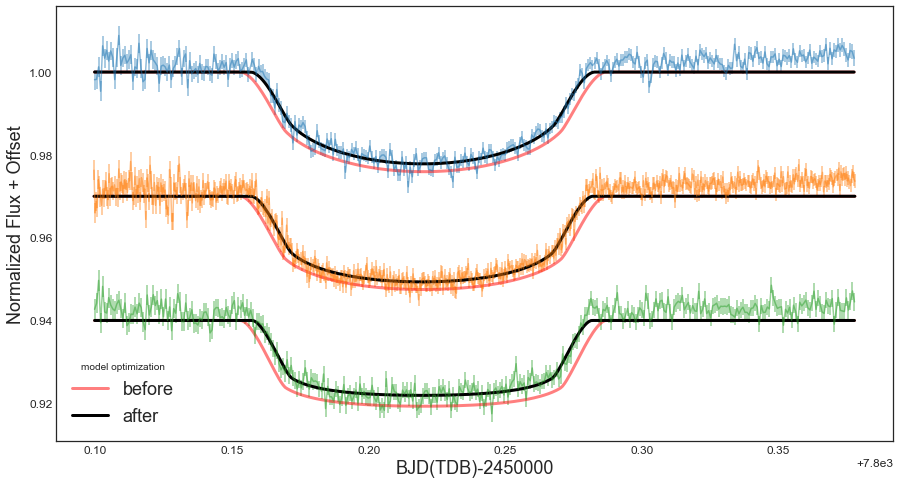

In [11]:
fig,ax = pl.subplots(1,1,figsize=(15,8))

optimized_transit_params = {} 

n=0
for b,u,c in zip(bands,ldc_list,colors):
    print('{}-band'.format(b))
    df=data[b]
    
    flux = df[fluxcol]
    time = df.index
    err  = df[errcol]
    
    #plot raw data with vertical offset
    offset = n*0.03
    pl.errorbar(time, flux-offset, yerr=err, alpha=0.5) 
    
    #compute q from u found in limbdark
    q1_,q2_ = u_to_q(u[0],u[1])

    #compute flux before optimization
    transit_params     = [k_,q1_,q2_,tc_0,_a_s,_b]
    transit_model_before  = transit_model_q(transit_params, _P, time)
    #rms before
    rms_before = rms(flux,transit_model_before)
    print('rms before: {:.4f}'.format(rms_before))
    
    #optimize parameters
    result = op.minimize(obj, transit_params,
                         args=(_P, time, flux, err), method='nelder-mead')
    
    #compute flux after optimization
    transit_params_after = np.copy(result.x)
    transit_model_after  = transit_model_q(transit_params_after, _P, time)
    
    #save transit model to original dataframe
    data[b]['transit_model'] = transit_model_after
    
    #rms after
    rms_after = rms(flux,transit_model_after)
    print('rms after: {:.4f}\n'.format(rms_after))
    
    #plot transit models
    #before (faint red)
    ax.plot(time, transit_model_before-offset, 'r-', lw=3, alpha=0.5)
    #after (black)
    ax.plot(time, transit_model_after-offset, 'k-', lw=3, alpha=1)
    ax.legend(fontsize=fontsize)
    
    #dict of optimized transit parameters to be used later
    optimized_transit_params[b] = transit_params_after
    n+=1
    
ax.set_ylabel('Normalized Flux + Offset', fontsize=fontsize)
ax.set_xlabel('BJD(TDB)-2450000', fontsize=fontsize)
ax.legend(['before','after'], title='model optimization',fontsize=fontsize)

In [12]:
optimized_transit_params

{'g': array([  1.28330953e-01,   6.94722181e-01,   4.65491536e-01,
          7.80021976e+03,   1.21625800e+01,   1.72028975e-01]),
 'r': array([  1.28408329e-01,   5.53907376e-01,   3.49739851e-01,
          7.80021952e+03,   1.22467056e+01,   1.72044914e-01]),
 'z': array([  1.25171086e-01,   3.43090243e-01,   2.07678538e-01,
          7.80021956e+03,   1.22930550e+01,   1.71164788e-01])}

## Systematics Modeling

See part4.

In [13]:
print('no. of data points:')
for b in bands:
    print('{}:\t{}'.format(b, len(data[b]['flux(r=11.0)'])))

no. of data points:
g:	375
r:	704
z:	376


In [14]:
#systematics model
def systematics_model(w, aux_vec):
    '''
    systematics model consists of linear combination
    of constant coefficients (computed here) 
    and auxiliary vectors:
    
    flux, vertical offset
    
    The functional form of the model is
    s = [np.sum(c[k] * x**k) for k in np.arange(N)]
    '''
    #make sure there are 4 aux. vectors
    
    X = np.c_[np.atleast_2d(aux_vec).T]
    
    #compute systematics model
    sys_model = np.dot(X,w)
        
    return sys_model

g-band
rms (resid): 0.0026
rms (resid - systematics model): 0.0017

rms difference: 0.0009

r-band
rms (resid): 0.0026
rms (resid - systematics model): 0.0017

rms difference: 0.0009

z-band
rms (resid): 0.0028
rms (resid - systematics model): 0.0017

rms difference: 0.0011



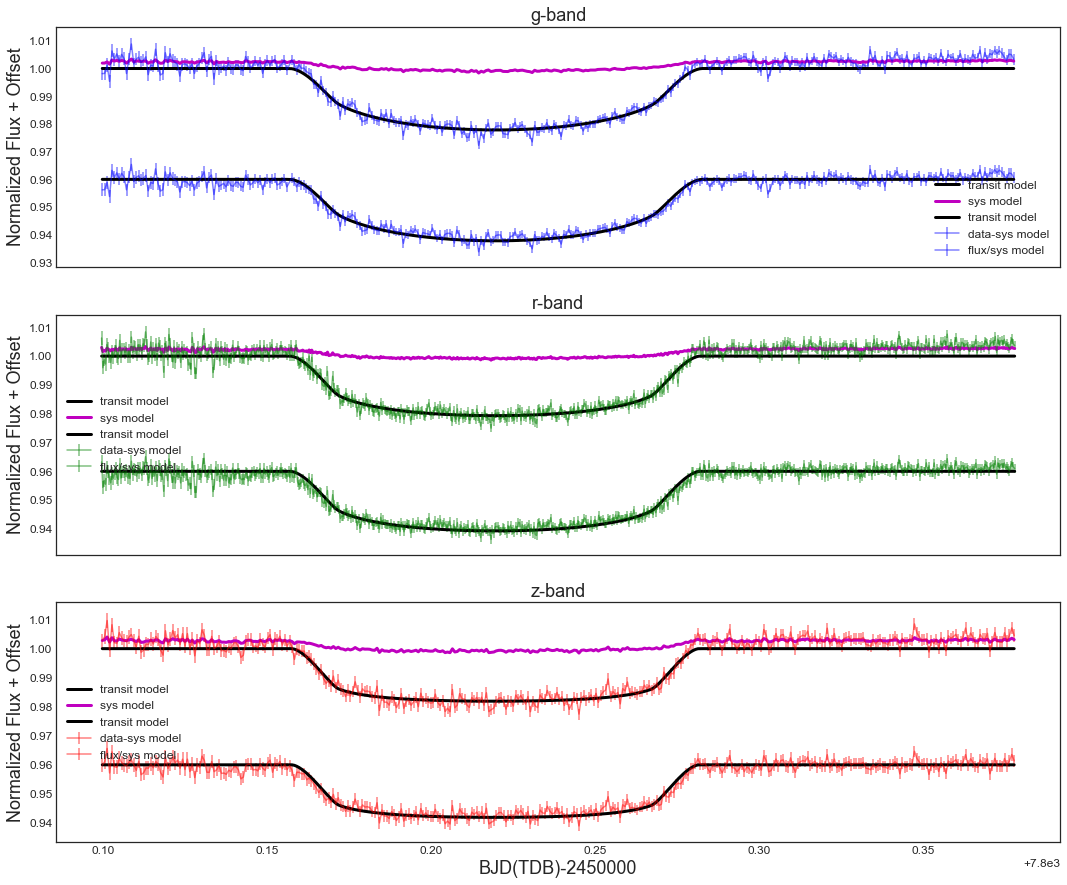

In [15]:
fig,ax = pl.subplots(3,1,figsize=(18,15), sharex=True)

X_list = {}
w_list = {}
#aux_vec_list = {}

n=0
for b,u,c in zip(bands,ldc_list,colors):
    print('{}-band'.format(b))
    df=data[b]
    
    flux = df[fluxcol]
    time = df.index
    err  = df[errcol]
    
    #plot flux raw data
    ax[n].errorbar(time, flux, yerr=err, 
                   label='data-sys model', alpha=0.5, color=c) 
    
    transit_params = optimized_transit_params[b]
    transit_model  = transit_model_q(transit_params, _P, time)
    
    #plot best fit transit model
    ax[n].plot(time, transit_model, 'k-', lw=3, label='transit model')
    data[b]['transit_model'] = transit_model 
    
    #plot residual with offset
    sys = flux / transit_model
    data[b]['flux/transit_model'] = sys
    
    ##ax[n].plot(time, resid+0.94, 'm-', lw=3, label='residual')
    ##ax[n].plot(time, sys+0.94, 'm-', lw=3, label='residual')
    
    #add vertical offset
    vert_offset = np.ones_like(flux)
    
    aux_vec = [flux, vert_offset]
    #aux_vec_list[b] = aux_vec_list
    
    #construct X with time
    X = np.c_[np.atleast_2d(aux_vec).T]
    X_list[b] = X
    
    #compute systematics model
    w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, sys))
    w_list[b] = w
        
    #evaluate model
    sys_model = systematics_model(w, aux_vec)
    
    data[b]['sys_model'] = sys_model
    
    resid = flux/sys_model - transit_model
    data[b]['residual'] = resid
    
    #compute rms
    rms_before = rms(flux, transit_model)
    #rms_after = rms(resid,sys_model)
    rms_after = rms(flux/sys_model,transit_model)
    
    print('rms (resid): {:.4f}'.format(rms_before))
    print('rms (resid - systematics model): {:.4f}\n'.format(rms_after))
    print('rms difference: {:.4f}\n'.format(rms_before-rms_after))
    
    
    
    #plot systematics model
    ax[n].plot(time, sys_model, 'm-', lw=3, label='sys model')
    
    #plot corrected flux
    ax[n].errorbar(time, flux/sys_model-0.04, yerr=err, 
                   label='flux/sys model', alpha=0.5, color=c) 
    ax[n].plot(time, transit_model-0.04, 'k-', lw=3, label='transit model')
    
    ax[n].set_title('{}-band'.format(b), fontsize=fontsize)
    ax[n].legend(fontsize=12)
    ax[n].set_ylabel('Normalized Flux + Offset', fontsize=fontsize)
    n+=1
    
pl.xlabel('BJD(TDB)-2450000', fontsize=fontsize)

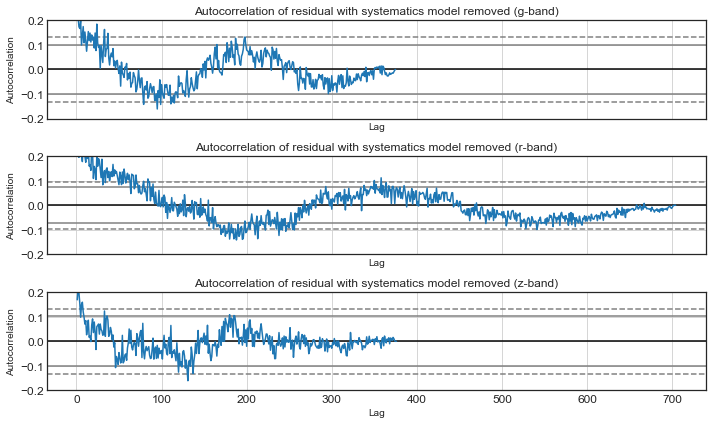

In [16]:
fig, ax = pl.subplots(nrows=3,ncols=1,figsize=(10,6), sharex=True)

n=0
for b in bands:
    df   = data[b]
    time = df.index
    
    #get residual computed earlier    
    resid_wo_sys = data[b]['residual']
        
    pd.plotting.autocorrelation_plot(resid_wo_sys, ax=ax[n])
    ax[n].set_title('Autocorrelation of residual with systematics model removed ({}-band)'.format(b))
    ax[n].set_ylim(-0.2,0.2)
    n+=1
fig.tight_layout()

In [29]:
def binned(a, binsize, fun=np.mean):
    a_b = []
    for i in range(0, a.shape[0], binsize):
        a_b.append(fun(a[i:i+binsize], axis=0))
        
    return np.array(a_b)

def binned_rms(residuals, timestep, start_min=5, stop_min=20):
    """
    residuals : flux/sys_model - transit_model
    timestep  : time interval between datapoints in seconds
    """

    assert timestep < start_min * 60
    ndata = len(residuals)

    min_bs = int(start_min * 60 / timestep)
    max_bs = int(stop_min  * 60 / timestep)

    rms_err      = []
    rms_err_dict = {}
    for bs in np.arange(min_bs, max_bs + 1):
        nbins = ndata / bs
                
        #binning       
        rms_val = np.sqrt(np.mean(binned(residuals,bs)**2))
        rms_err.append(rms_val)
        rms_err_dict[bs] = rms_val
        
    return rms_err_dict

In [30]:
rms_binned = {}

exptimes = [60,30,60] #sec

for b,ts in zip(bands,exptimes):
    df=data[b]
    
    ndata = len(df)
    nparams = 2
    
    time  = df.index
    flux  = df[fluxcol].values
    err   = df[errcol].values
    
    transit_model = transit_model_q(optimized_transit_params[b], _P, time)
    sys    = flux/transit_model
    X = np.c_[flux, np.ones_like(flux)]
    w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, sys))
    sys_model = np.dot(X,w)
    
    data[b]['transit_model'] = transit_model 
    data[b]['sys_model'] = sys_model
    
    resid = flux/sys_model - transit_model
    data[b]['residual'] = resid
    
    #resid = df['residual'].values
    rms_bin = binned_rms(resid, ts, start_min=5, stop_min=40)
    rms_binned[b] = rms_bin

(0, 40)

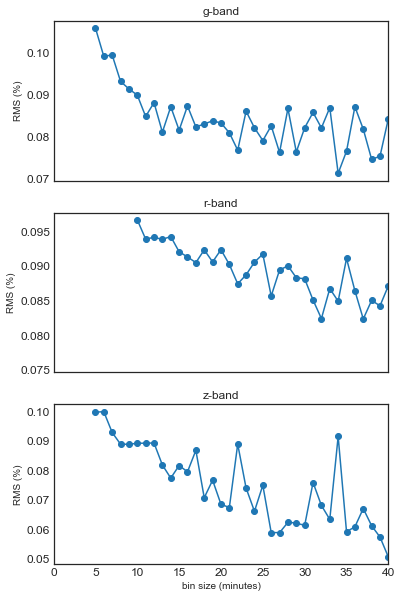

In [31]:
fig,ax=pl.subplots(3,1,figsize=(6,10), sharex=True)
b='g'
n=0
for b in bands:
    ax[n].plot(list(rms_binned[b].keys()),
               np.array(list(rms_binned[b].values()))*100, 'o-')
    ax[n].set_title('{}-band'.format(b))
    ax[n].set_ylabel('RMS (%)')
    #ax[n].set_ylim(-0.001,0.001)
    n+=1
ax[n-1].set_xlabel('bin size (minutes)')
ax[n-1].set_xlim(0,40)

## Reduced $\chi^2$

In [19]:
def chisq(resid, err, ndata=None, nparams=None, reduced=False):
    '''
    resid: residual = flux/sys_model - transit_model
    err  : error in flux
    '''
    if reduced:
        assert ndata is not None and nparams is not None
        dof = ndata - nparams
        return sum((resid / err)**2) / (dof)
    else:
        return sum((resid / err)**2)

In [32]:
reduced_chi2 = {}

newerrcols = []

for b in bands:
    df = data[b]
    ndata = len(df)
    nparams = 2
    
    time  = df.index
    flux  = df[fluxcol]
    err   = df[errcol]
        
    resid = data[b]['residual']
    
    #resid = df['resid']
    chi2 = chisq(resid, err, reduced=False)
    red_chi2 = chisq(resid, err, ndata, nparams, reduced=True)
    
    #save
    reduced_chi2[b] = red_chi2
    col='err(r=11.0)*{:.2f}'.format(red_chi2)
    newerrcols.append(col)
    
    #inflate error
    if red_chi2>1:
        df[col] = err*red_chi2
    #be conservative and preserve orig err
    else: 
        df[col] = err
    
    #print(len(err*factor))
    print('chi2 ={:.4f}'.format(chi2))
    print('reduced chi2 ={:.4f}'.format(red_chi2))

chi2 =397.0913
reduced chi2 =1.0646
chi2 =760.6287
reduced chi2 =1.0835
chi2 =273.3496
reduced chi2 =0.7309


In [21]:
reduced_chi2

{'g': 1.06458782206387, 'r': 1.0835165962464715, 'z': 0.73088123909314506}

## beta factor

In [33]:
def binned(a, binsize, fun=np.mean):
    a_b = []
    for i in range(0, a.shape[0], binsize):
        a_b.append(fun(a[i:i+binsize], axis=0))
        
    return a_b

def beta(residuals, timestep, start_min=5, stop_min=20, return_dict=False):
    """
    residuals : flux/sys_model - transit_model
    timestep  : time interval between datapoints in seconds
    
    Final beta is computed by taking the median of the betas:
                np.nanmedian(betas)
    """

    assert timestep < start_min * 60
    ndata = len(residuals)
    
    sigma1 = np.std(residuals)

    min_bs = int(start_min * 60 / timestep)
    max_bs = int(stop_min  * 60 / timestep)

    betas      = []
    betas_dict = {}
    for bs in np.arange(min_bs, max_bs + 1):
        nbins = ndata / bs
        sigmaN_theory = sigma1 / np.sqrt(bs) * np.sqrt( nbins / (nbins - 1) )
        
        #binning
        sigmaN_actual = np.std(binned(residuals,bs))
        beta = sigmaN_actual / sigmaN_theory
        
        betas_dict[bs] = beta
        betas.append(beta)
        
    if return_dict:
        return betas_dict
    else:
        return np.nanmedian(betas)

In [34]:
beta_factor_list = {}

exptimes = [60,30,60] #sec

for b,col,ts in zip(bands,newerrcols,exptimes):
    df = data[b]
    resid = df['residual'].values
    
    beta_fac = beta(resid, ts, start_min=5, stop_min=20, return_dict=True)
    beta_factor_list[b]= beta_fac

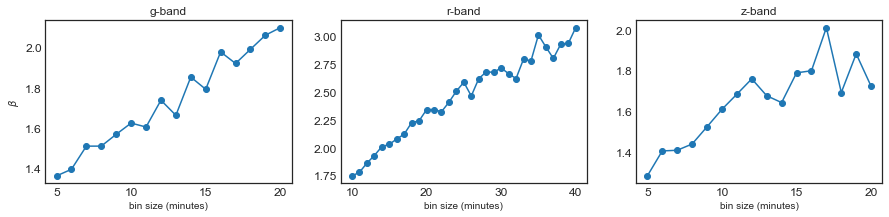

In [35]:
fig,ax=pl.subplots(1,3,figsize=(15,3))
b='g'
n=0
for b in bands:
    ax[n].plot(list(beta_factor_list[b].keys()),list(beta_factor_list[b].values()),'o-')
    ax[n].set_title('{}-band'.format(b))
    ax[n].set_xlabel('bin size (minutes)')
    n+=1
ax[0].set_ylabel(r'$\beta$')

In [36]:
beta_factor = {}

exptimes = [60,30,60] #sec

for b,col,ts in zip(bands,newerrcols,exptimes):
    df = data[b]
    resid = df['residual'].values
    
    beta_fac = beta(resid, ts, start_min=5, stop_min=20)
    beta_factor[b]= beta_fac
    
    err = df[col]
    
    #inflate error once more (after rescaling red. chi-squared)
    inflated_err = err * beta_fac
    
    #add to df 
    data[b]['err_inflated'] = inflated_err
    
    print('beta factor ={:.4f}'.format(beta_fac))

beta factor =1.7011
beta factor =2.5077
beta factor =1.6793


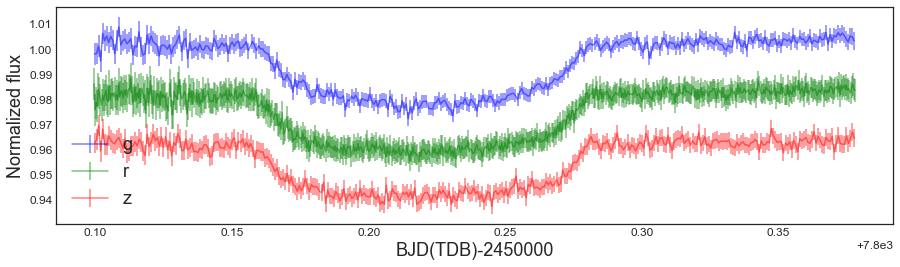

In [37]:
import matplotlib.pyplot as pl
%matplotlib inline

fluxcol =  'flux(r=11.0)'
errcol  =  'err_inflated' #'err(r=11.0)'

colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))

n=0
for b,c in zip(bands,colors):
    df = data[b]
    offset = n*0.02
    
    time = df.index
    flux = df[fluxcol]
    err  = df[errcol]
    
    ax.errorbar(time, flux-offset, yerr=err, label=b, color=c, alpha=0.5)
    ax.set_ylabel('Normalized flux', fontsize=fontsize)
    n+=1
pl.legend(loc='lower left', fontsize=fontsize)
pl.xlabel('BJD(TDB)-2450000', fontsize=fontsize)

fig.savefig('inflated_err.png')

In [38]:
errs=[]
for b in bands:
    df=data[b]
    errs.append(df['err_inflated'])  

---

## Transit model parameter estimation: Bayesian approach

* Simultaneous modeling
 * transit model
 * systematics model
* Bayes' theorem
 * Likelihood
 * Prior
* MCMC using `emcee` (part6)

### Bayes' Theorem

![img](images/bayes.png)

Goal:
* estimate the posterior probability for the model parameters given 
 * their prior probabilities and 
 * a set of observations/ data. 

The posterior probability density given a parameter vector $\theta$ and observational data $D$ is described by the Bayes' theorem as (c.f. [wiki](https://en.wikipedia.org/wiki/Bayes%27_theorem)):

$$
P(\theta|D) \propto P(\theta) \times P(D|\theta) \\
\rm{Posterior \propto Prior \times Likelihood}
$$
where $P(\theta)$ is the prior, $P(D|\theta)$ is the likelihood for the data.

### Likelihood for transit & systematics parameters

Assuming that the variables in our model are independent, identically distributed ([iid](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)) random variables, we can expect that the residual (data - transit - systematics model) follows a Gaussian distribution. 

$$
\mathcal{L}(\theta|M) = N(\mu,\sigma) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp-\frac{(x-\mu)^2}{2\sigma^2}
$$

See Appendix for a simple demonstration.

### $\log$ Likelihood (ll)

The likelihood is a product of individual observation probabilities, and has the unfortunate tendency to end up being either very small or very big. This causes computational headaches, and it is better to work with log probabilities instead, so that

$$
\ln \mathcal{L}(\theta|D) = \ln\Big[(2\pi\sigma^2)^{-\frac{1}{2}}\Big] +\ln \Big[\exp\Big(-\frac{(x-\mu)^2}{2\sigma^2}\Big)\Big] \\
\log \mathcal{L}(\theta|D) = -\frac{1}{2}\ln(2\pi) -\frac{1}{2}\ln \sigma^2 -\frac{(x-\mu)^2}{2\sigma^2} \\
\log \mathcal{L}(\theta|D) = -\frac{1}{2}\Big[\ln(2\pi) +2\ln\sigma +\Big(\frac{x-\mu}{\sigma}\Big)^2\Big]
$$

Now, let's write a function that computes the value above.

In [39]:
def loglike(params_full, p, t, f, err, aux_vec, log2pi = np.log(2*np.pi),
            ret_mod=False, ret_sys=False, ret_full = False):
    '''
    * computes the log likelihood given the optimized transit and model parameters
    * either or both transit and systematics models can also be returned
    '''
    
    m = transit_model_q(params_full[:6], p, t)
    
    #color1,color2,dx,err = aux_vec
    s = systematics_model(params_full[6:], aux_vec) # #add sys model
    
    if ret_mod:
        return m
    if ret_sys:
        return s
    if ret_full:
        return m*s
    
    resid = f / s - m 
    div   = resid/err
    N     = div.size    
    
    return -np.sum(np.log(err)) -0.5*N*log2pi -0.5*np.dot(div,div)

### negative log likelihood (nll)

Goal:
* Maximize likelihood but `scipy.optimize.minimize` is (only?) available
* Use nll instead! --> minimizing nll == maximizing ll !!!

In [40]:
#negative log-likelihood
nll = lambda *x: -loglike(*x)

## Simultaneous modeling of transit and systematics parameters
### MLE optimization

--g--
NLL before: -1868.8106264001615
NLL after: -1886.9001506941304
--r--
NLL before: -3507.9901742758784
NLL after: -3550.373768530833
--z--
NLL before: -1853.1604127416037
NLL after: -1868.0270377600666


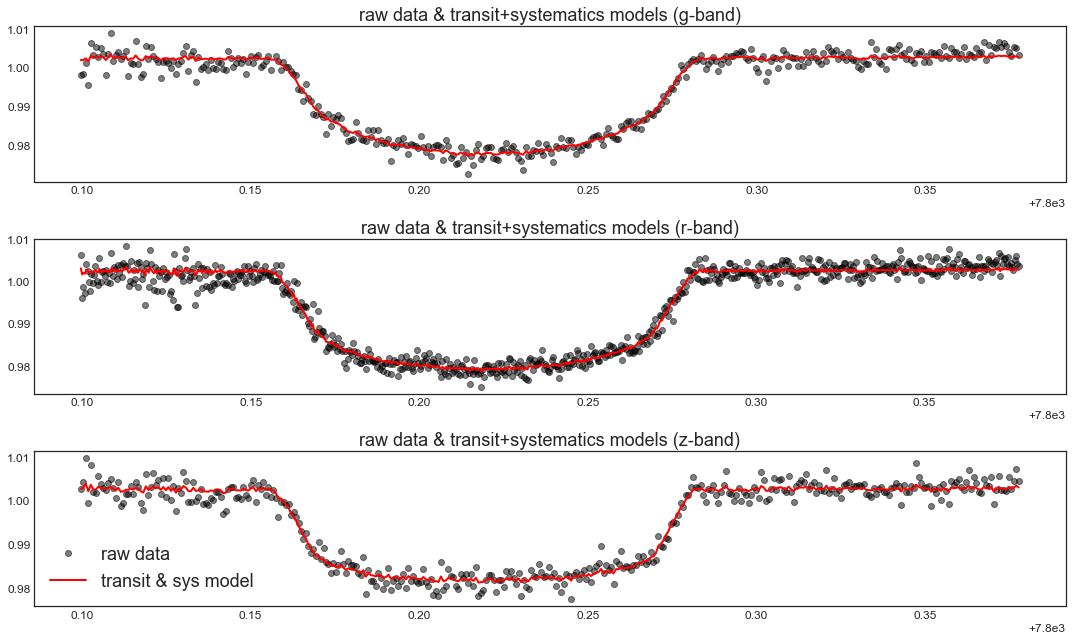

In [41]:
#parameters vector: 6 transit, 4+2 systematics

import scipy.optimize as op
fig = pl.figure(figsize=(15,9))

save_model = True

n=0
for b in bands:
    df=data[b]

    flux = df[fluxcol]
    time = df.index

    #sys mod params
    err       = df['err(r=11.0)']
    print('--{}--'.format(b))
    
    #transit params computed before
    transit_params = optimized_transit_params[b]
    
    #weights computed before
    w = w_list[b]
    
    #aux_vec saved before
    #aux_vec = aux_vec_list[b]
    aux_vec = [flux, np.ones_like(flux)]
    #combine optimized transit params and sys params
    full_params = np.concatenate((transit_params, w), axis=0)
    
    #compute nll
    print ("NLL before: {}".format(nll(full_params, 
                                       _P, 
                                       time, 
                                       flux, 
                                       err, 
                                       aux_vec)))
    #MLE optimization of transit+sys parameters
    result = op.minimize(nll, full_params,    
                         args=(_P, time, flux, err, aux_vec),
                         method='nelder-mead')
    
    #result of optimization
    print ("NLL after: {}".format(nll(result.x,   
                                      _P, 
                                      time, 
                                      flux, 
                                      err, 
                                      aux_vec)))
    
    #compute models
    full_model    = loglike(result.x, _P, time, flux, err, aux_vec, 
                            ret_full=True)
    transit_model = loglike(result.x, _P, time, flux, err, aux_vec, 
                     ret_mod=True)
    sys_model     = loglike(result.x, _P, time, flux, err, aux_vec, 
                     ret_sys=True)
    
    resid = flux/sys_model - transit_model
    
    if save_model:
        data[b]['transit_model'] = transit_model
        data[b]['sys_model']     = sys_model
        data[b]['full_model']    = full_model
        data[b]['residual']      = resid
    
    rms   = np.sqrt(np.mean(resid**2))
    
    ax = pl.subplot(3,1,n+1)
    #plot corrected data
    ax.plot(time, flux, 'ko', alpha=0.5, label='raw data')
    ax.set_title('raw data & transit+systematics models ({}-band)'.format(b), fontsize=fontsize)
    #plot transit+sys models
    ax.plot(time, full_model, 'r-', lw=2, label='transit & sys model');
    n+=1
    
pl.legend(fontsize=fontsize)
fig.tight_layout()

### Priors for transit parameters

Giving a prior on a parameter puts limits/bounds on the range of values it can have.

The simplest prior is a uniform prior $U(x_1,x_2)$ where it is 1 within the interval $x_1,x_2$ and 0 elsewhere. 
* UP  - Impact parameter
* UP  - White noise std
* UP  - limb darkening q1
* UP - limb darkening q2

Another useful prior is a normal prior $N(\sigma,\mu)$ centered at $\mu$ and has a thickness $\sigma$.
* NP  - Transit centre
* NP  - Period
* NP  - Stellar density
* NP  - Baseline constant
* JP  - planet-star area ratio

![image](images/bias.jpg)

Perhaps we can set the minimum width of the uniform prior for a given parameter by taking into account their measurement uncertainties. 

In [42]:
import numpy as np
from uncertainties import ufloat 
from astropy import units as u

P   = ufloat(4.301219,0.000019)
Rp  = ufloat(1.523,0.442)   #+0.442-0.226

Rs_jup  = 0.949*u.Rsun.to(u.Rjup)
Rs_jup_u= 0.08*u.Rsun.to(u.Rjup) #+0.08/-0.037
Rs  = ufloat(Rs_jup,Rs_jup_u)

t14 = ufloat(0.1302,0.0008) 
b   = ufloat(0.172,0.079)   #+0.079/-0.074     
a_s = ufloat(11.52,0.74)
k   = ufloat(np.sqrt(0.01804),np.sqrt(0.00027)) 
inc = ufloat(np.deg2rad(89.10),np.deg2rad(0.4))

In [43]:
#uncertainty in k from Rp/Rs
Rp/Rs

0.16491840817134548+/-0.04984031996673391

In [44]:
#uncertainty in k from transit depth
k

0.13431306712304653+/-0.016431676725154984

Rp/Rs doesn't seem to provide good constraint on k because of the large uncertainty.

For scaled semi-major axis,

In [45]:
def scaled_a(p, t14, k, i=np.pi/2, impact_param=0):
    """
    a/Rs: scaled semi-major axis
    
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    numer = np.sqrt( (k + 1)**2 - impact_param**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

_t14  = 0.13020
_b    = 0.172
a_s_  = scaled_a(_P, _t14, k_, i=_inc, impact_param=_b)
a_s_

11.80879179358181

The propagated uncertainty is

In [46]:
from uncertainties.umath import *

num   = ((k + 1)**2 - b**2)**(0.5)
denom = sin(inc) * sin(t14 * np.pi / P)

#uncertainty in a_s
a_s = num/denom
a_s

11.809211418629959+/-0.22844457501225646

In [47]:
#bounds
a_s.n-a_s.s, a_s.n+a_s.s 

(11.580766843617702, 12.037655993642215)

For the transit center, tc, it should be between t1 and t4:

In [48]:
tc_0-_t14/2, tc_0+_t14

(7800.1549, 7800.3502)

[Seager+2003]() derived the theoretical maximum value for k=Rp/Rs:

In [49]:
def tshape_approx(a, k, b):
    """
    Seager & Mallen-Ornelas 2003, eq. 15
    """
    i = np.arccos(b/a)
    alpha = (1 - k)**2 - b**2
    beta = (1 + k)**2 - b**2
    return np.sqrt( alpha / beta )


def max_k(tshape):
    """
    Seager & Mallen-Ornelas 2003, eq. 21
    """
    return (1 - tshape) / (1 + tshape)

In [50]:
tshape = tshape_approx(_a_s, k_, _b)
kmax = max_k(tshape)
kmax

0.13844708892657234

In [51]:
import astropy.units as u
import astropy.constants as c

def rhostar(p, a):
    """
    Eq.4 of Kipping 2014. 
    Assumes circular orbit & Mp<<Ms
    
    http://arxiv.org/pdf/1311.1170v3.pdf
    
    c.f. Seager & __ 2002
    """
    p = p * u.d
    gpcc = u.g / u.cm ** 3
    rho_mks = 3 * np.pi / c.G / p ** 2 * a ** 3
    return rho_mks.to(gpcc).value

Stellar density

In [52]:
rhostar(_P,_a_s)

1.5632432442092328

We can now put the reasonable values above into our logprior function.

In [53]:
from scipy import stats
def logprior(full_params,u_prior=None):
    '''
    full_paras: transit+systematic model parameters
    up: limb-darkening prior for u1,u2
    '''
    #unpack transit parameters
    k,q1,q2,tc,a_s,impact_param = full_params[:6]
    inc=np.arccos(impact_param/a_s)
    
    tshape = tshape_approx(a_s, k_, _b)
    kmax = max_k(tshape)
    
    rho_s = rhostar(_P, a_s)

    #Uniform priors: return log 0= inf if outside interval
    if  q1  < 0 or q1 > 1 or \
        q2  < 0 or q2 > 1 or \
        k   < 0 or k  > kmax or \
        impact_param   < 0 or impact_param  > 1 or \
        inc > np.pi/2     or \
        a_s < 0 or a_s  > 13 or \
        rho_s < 1 or rho_s > 10 or \
        tc < tc_0-_t14/2 or tc > tc_0+_t14:
        
        #print('off limits encountered in logprior')
        return -np.inf
    
    #if they are inside interval, add log 1 = 0 to logprior
    
    #logprior
    lp = 0
    
    #Normal priors on q1,q2 with sigma=uncertainty from Claret+2012
    u1,u2 = q_to_u(q1,q2)
    
    if u_prior is not None:
        #evaluate log of N(u,sigma)
        sigma1=u_prior[1]
        sigma2=u_prior[3]
        #add to logprior
        lp += np.log(stats.norm.pdf(u1, loc=u_prior[0], scale=sigma1))
        lp += np.log(stats.norm.pdf(u2, loc=u_prior[2], scale=sigma2))
    
    #what are our priors for systematics model parameters?
    
    return lp

Evaluate logprior

In [54]:
logprior(full_params)

0

This means that the transit parameters are within the bounds set by the prior.

### logprob=logprior+loglike

Let's combine logprior and loglike into one function called logprob.

In [55]:
param_names='k_g,k_g,k_z,tc,a,b,q1g,q2g,q1r,q2r,q1z,q2z,w0g,w1g,w0r,w1r,w0z,w1z'.split(',')

In [56]:
def logprob(full_params,
            time_list,
            flux_list,
            period,
            err_list,
            ldc_prior=None):
    
    t1,t2,t3                   = time_list
    f1,f2,f3                   = flux_list
    err1,err2,err3             = err_list
    #airmass1,airmass2,airmass3 = airmass_list
    #ycen1,ycen2,ycen3         = dy_list
    
    #unpack full params for 3 bands
    k_g,k_g,k_z,tc,a,impact_param,q1g,q2g,q1r,q2r,q1z,q2z,\
    w0g,w1g,w0r,w1r,w0z,w1z = full_params
    
    #set up params list for each band
    theta1 = [k_g,q1g,q2g,tc,a,impact_param,w0g,w1g]
    theta2 = [k_r,q1r,q2r,tc,a,impact_param,w0r,w1r]
    theta3 = [k_z,q1z,q2z,tc,a,impact_param,w0z,w1z]
    
    #set up auxiliary vector for each band
    aux_vec1 = [f1, np.ones_like(f1)]
    aux_vec2 = [f2, np.ones_like(f2)]
    aux_vec3 = [f3, np.ones_like(f3)]
    
    #sum loglike for each band
    ll  = loglike(theta1, period, t1, f1, err1, aux_vec1)
    ll += loglike(theta2, period, t2, f2, err2, aux_vec2)
    ll += loglike(theta3, period, t3, f3, err3, aux_vec3)
    
    if ldc_prior is not None:
        lp  = logprior(theta1, u_prior=ldc_prior[0])
        lp += logprior(theta2, u_prior=ldc_prior[1])
        lp += logprior(theta3, u_prior=ldc_prior[2])
    else:
        #no ldc prior (if stellar parameters not known)
        lp  = logprior(theta1)
        lp += logprior(theta2)
        lp += logprior(theta3)
    
    if np.isnan(ll).any():
        #print('NaN encountered in loglike')
        return -np.inf
    
    #total: sum of prior and likelihood
    return lp + ll

#negative log prob
nlp = lambda *x: -logprob(*x)

Set-up vectors for transit model.

In [57]:
#ignore tc, a_s, b
k_g,q1g,q2g,_,_,_ = optimized_transit_params['g']
k_r,q1r,q2r,_,_,_ = optimized_transit_params['r']
k_z,q1z,q2z,_,_,_ = optimized_transit_params['z']

Set-up the necessary vectors for systematics model.

In [58]:
times    = []
fluxes   = []
errs     = []

for b in bands:
    #sys mod params
    df = data[b]
    times.append(df.index)
    fluxes.append(df['flux(r=11.0)'])
    errs.append(df['err(r=11.0)'])    

In [59]:
flux_coeffs   = []
vert_offsets = []

for b in bands:
    flux_coeffs.append(w_list[b][0])
    vert_offsets.append(w_list[b][1])

In [60]:
#unpack
w0g,w0r,w0z = flux_coeffs
w1g,w1r,w1z = vert_offsets

In [61]:
full_params = [k_g,k_g,k_z,tc_0,_a_s,_b,q1g,q2g,q1r,q2r,q1z,q2z,\
                w0g,w1g,w0r,w1r,w0z,w1z]

Evaluate `logprob` without `ldc_prior`:

In [62]:
logprob(full_params,
        times,
        fluxes,
        _P,
        errs,
        ldc_prior=None)

7108.8914543245974

This is the total log probability for the transit and systematics models for 3 bands without prior on limb-darkening coefficients.

Now, evaluate `logprob` with `ldc_prior=ldp`:

In [63]:
logprob(full_params,
        times,
        fluxes,
        _P,
        errs,
        ldc_prior=ldp)

7122.6465915276713

This is the total log probability for the transit and systematics models for 3 bands with prior on limb-darkening coefficients. 

We will use `nlp` later when we try to maximize the `logprob` to get the best fit parameters.